In [47]:
import pandas as pd
from pandas.tseries.offsets import *
import requests
import matplotlib.pyplot as plt
import numpy as np
from datetime import date, timedelta, datetime

today=(date.today() - timedelta(days=1)).strftime("%Y-%m-%d")
load_new=False
metrics = {"Deaths":"newDeaths28DaysByDeathDate","Cases":"newCasesBySpecimenDate","Hospitalisations":"hospitalCases"}
dfs={"Deaths":pd.DataFrame(),"Cases":pd.DataFrame(),"Hospitalisations":pd.DataFrame()}
for metric in metrics.keys():
    links = {
        #"total":"https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newDeaths28DaysByDeathDateRate&format=csv",
        #"england":["https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=%s&format=csv&release=%s"%(metrics[metric],today),56286961],
        "wales":["https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=W92000004&metric=%s&format=csv&release=%s"%(metrics[metric],today),3152879],
        #"scotland":["https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=S92000003&metric=%s&format=csv&release=%s"%(metrics[metric],today),5463300],
        #"ireland":"https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=N92000002&metric=newDeaths28DaysByDeathDateRate&format=csv"
    }
    for link in links:
        if load_new==True:
            f = requests.get(links[link][0])

            with open("%s_%s.csv"%(link,metric),"w+") as out:
                out.seek(0)
                out.write(f.text)
                out.truncate()

        area_data = pd.read_csv("%s_%s.csv"%(link,metric))
        area_data.dropna()#There are nan values in feb before deaths started and yesterday where reporting isn't complete
        area_data=area_data[::-1].reset_index()#Results are indexed backwards in time
        dfs[metric].insert(0,link,[n/(links[link][1]/100000) for n in area_data[metrics[metric]].rolling(7).mean().to_list()[:-3]])#Drops the last few days because they're always way less since the deaths not yet reported
        dfs[metric]["date"]=area_data["date"]

In [23]:
def plotDeaths(include):
    plt.rcParams["figure.figsize"] = (15,10)
    fig,ax = plt.subplots()

    ax.plot(dfs["Deaths"].loc[dfs["Deaths"]['date'] == "2020-03-23"]["england"],marker="o",label="National lockdown announcement",color="grey")
    ax.plot(dfs["Deaths"].loc[dfs["Deaths"]['date'] == "2020-03-26"]["england"],marker="o",label="National lockdown legally began",color="red")

    for link in include:
        ax.plot(dfs["Deaths"][link],"--",label=link)
        ax.plot(dfs["Deaths"].loc[dfs["Deaths"]['date'] == "2020-03-23"][link],marker="o",color="grey")
        ax.plot(dfs["Deaths"].loc[dfs["Deaths"]['date'] == "2020-03-26"][link],marker="o",color="red")
        ax.errorbar(dfs["Deaths"].index[dfs["Deaths"]['date'] == "2020-04-11"],dfs["Deaths"].loc[dfs["Deaths"]['date'] == "2020-04-11"][link].values[0], xerr=3.5,marker="o",color="grey")
        ax.errorbar(dfs["Deaths"].index[dfs["Deaths"]['date'] == "2020-04-14"],dfs["Deaths"].loc[dfs["Deaths"]['date'] == "2020-04-14"][link].values[0], xerr=3.5,marker="o",color="red")

    if "england" in include:
        ax.plot(dfs["Deaths"].loc[dfs["Deaths"]['date'] == "2020-10-13"]["england"],marker="o",label="England tier System began",color="black")
        ax.plot(dfs["Deaths"].loc[dfs["Deaths"]['date'] == "2020-11-05"]["england"],marker="o",label="England lockdown 2 began",color="red")
        ax.errorbar(dfs["Deaths"].index[dfs["Deaths"]['date'] == "2020-04-11"],dfs["Deaths"].loc[dfs["Deaths"]['date'] == "2020-04-11"]["england"].values[0], xerr=3.5,marker="o",label="National announcement plus 19 days",color="grey")
        ax.errorbar(dfs["Deaths"].index[dfs["Deaths"]['date'] == "2020-04-14"],dfs["Deaths"].loc[dfs["Deaths"]['date'] == "2020-04-14"]["england"].values[0], xerr=3.5,marker="o",label="National lockdown plus 19 days",color="red")
        ax.errorbar(dfs["Deaths"].index[dfs["Deaths"]['date'] == "2020-11-01"],dfs["Deaths"].loc[dfs["Deaths"]['date'] == "2020-11-01"]["england"].values[0], xerr=3.5,marker="o",label="England tier system 1 plus 19 days",color="black")
        ax.errorbar(dfs["Deaths"].index[dfs["Deaths"]['date'] == "2020-11-24"],dfs["Deaths"].loc[dfs["Deaths"]['date'] == "2020-11-24"]["england"].values[0], xerr=3.5,marker="o",label="England lockdown 2 plus 19 days",color="red")
    if "wales" in include:  
        ax.plot(dfs["Deaths"].loc[dfs["Deaths"]['date'] == "2020-10-23"]["wales"],marker="o",label="Wales lockdown 2 began",color="red")
        ax.errorbar(dfs["Deaths"].index[dfs["Deaths"]['date'] == "2020-11-11"],dfs["Deaths"].loc[dfs["Deaths"]['date'] == "2020-11-11"]["wales"].values[0], xerr=3.5,marker="o",label="Wales lockdown 2 plus 19 days",color="red")
    if "scotland" in include:
        ax.plot(dfs["Deaths"].loc[dfs["Deaths"]['date'] == "2020-10-23"]["scotland"],marker="o",label="Scotland tier system announced",color="grey")
        ax.plot(dfs["Deaths"].loc[dfs["Deaths"]['date'] == "2020-11-02"]["scotland"],marker="o",label="Scotland tier system began",color="black")
        ax.errorbar(dfs["Deaths"].index[dfs["Deaths"]['date'] == "2020-11-21"],dfs["Deaths"].loc[dfs["Deaths"]['date'] == "2020-11-21"]["scotland"].values[0], xerr=3.5,marker="o",label="Scotland tier system plus 19 days",color="black")
        ax.errorbar(dfs["Deaths"].index[dfs["Deaths"]['date'] == "2020-11-11"],dfs["Deaths"].loc[dfs["Deaths"]['date'] == "2020-11-11"]["scotland"].values[0], xerr=3.5,marker="o",label="Scotland tier system announcement plus 19 days",color="grey")

    ax.set_xlabel("Days since 3$^{rd}$ January 2020")
    ax.set_ylabel("COVID 19 Deaths per 100k (that occured on the day)")
    ax.set_title("COVID 19 Deaths")

    ax.legend()

In [19]:
def plotMetrics(include,exclude=[]):
    plt.rcParams["figure.figsize"] = (15,10)
    fig,ax = plt.subplots()
    ax2=ax.twinx()
    for metric in metrics:
        if metric not in exclude:
            for nation in include:
                if metric!="Deaths":
                    ax.plot([datetime.strptime(d,'%Y-%m-%d').timetuple().tm_yday for d in dfs[metric]["date"]],dfs[metric][nation],label="%s %s"%(nation,metric))
                else:
                    ax2.plot([datetime.strptime(d,'%Y-%m-%d').timetuple().tm_yday for d in dfs[metric]["date"]],dfs[metric][nation],label="%s %s"%(nation,metric))#,color="red")
    ax.set_xlabel("Days since Jan 1$^{st}$")
    ax.set_ylabel("Per 100k")
    ax2.set_ylabel("Deaths per 100k")
    ax.legend()
    ax2.legend()
    """if "wales" in include:
        ax.scatter(318-2,dfs["Cases"]["wales"][318-2])
        ax2.errorbar(318+19,dfs["Deaths"]["wales"][318+19],xerr=3.5,marker="x",color="red")
    if "england" in include:
        #ax.scatter(333,dfs["Cases"]["england"][335-57])
        ax2.plot([335+17,335+17],[0,1])
        #ax2.errorbar(335+19-57,dfs["Deaths"]["england"][335+19-57],xerr=3.5,marker="x",color="red")"""

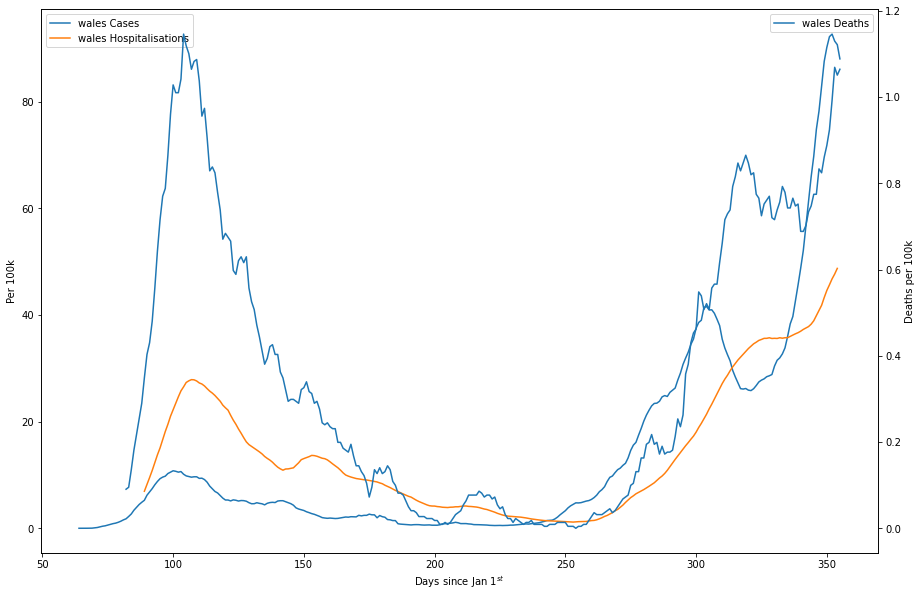

In [48]:
plotMetrics(["wales"])

KeyError: 'scotland'

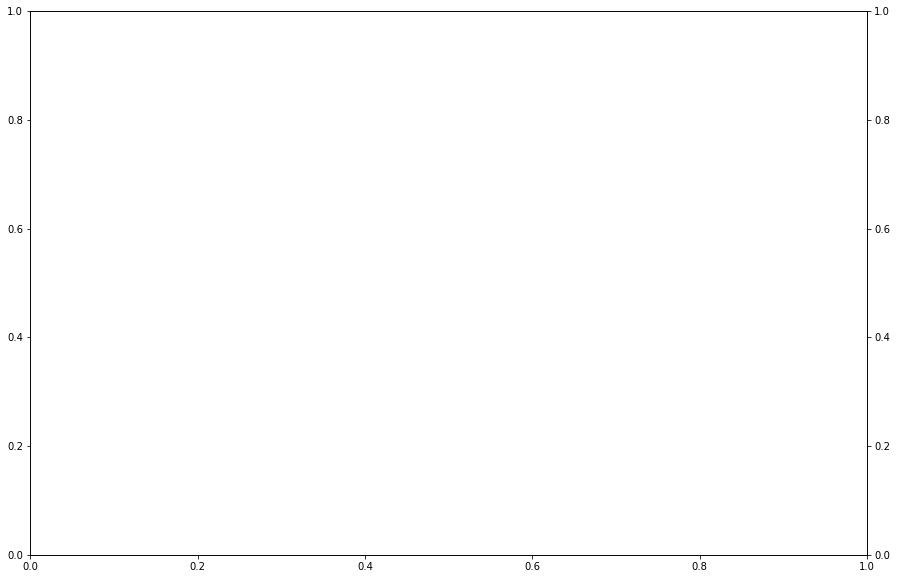

In [43]:
plotMetrics(["scotland","england"],exclude=["Deaths"])

In [ ]:
plotDeaths(["england","wales"])

18.5±3.5 days is average days to death(https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30566-3/fulltext#tbl2). You can clearly see deaths dropping in both England and Wales almost exactly this amount of time after both lockdowns were implimented.

In [ ]:
plotDeaths(["england","wales","scotland"])

When Scotland is included it appears that deaths in Scotland respond to the announcement of the measures rather than their legal implimentation. It also appears that Scotland's tier system is effective where England's was not.

In [ ]:
plotDeaths(["wales","scotland"])

Clearer without England cluttering up the end.

In [3]:
dfs["Deaths"]

,england,date
0,NaN,2020-03-02
1,NaN,2020-03-03
2,NaN,2020-03-04
3,NaN,2020-03-05
4,NaN,2020-03-06
...,...,...
287,0.639326,2020-12-14
288,0.637296,2020-12-15
289,0.619529,2020-12-16
290,0.617499,2020-12-17


In [67]:
dfs["Cases"]

,england,date
0,NaN,2020-01-30
1,NaN,2020-01-31
2,NaN,2020-02-01
3,NaN,2020-02-02
4,NaN,2020-02-03
...,...,...
322,43.451068,2020-12-17
323,45.309149,2020-12-18
324,45.558382,2020-12-19
325,44.580738,2020-12-20


In [2]:
dfs["Hospitalisations"]

""
